# Previsão de Indicadores de Call Center com Gradient Boosting
    
Este notebook demonstra a aplicação de um modelo de Gradient Boosting para prever o numerador e o denominador de indicadores de call center (CSAT, Nota de Qualidade e TMA) com base em dados de data e variáveis categóricas.   

In [17]:
pip install scikit-learn matplotlib seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## 1. Geração de Dados Fictícios
Para este exemplo, geraremos uma base de dados fictícia que simula informações de um call center. Esta base incluirá datas, IDs de login de agentes, nomes de indicadores (CSAT, Nota de Qualidade, TMA), valores de numerador e denominador, e grupos de agentes.

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

In [ ]:
def generate_call_center_data(num_rows=1000):
    np.random.seed(42)

    # Datas
    start_date = datetime(2024, 1, 1)
    dates = [start_date + timedelta(days=np.random.randint(0, 365)) for _ in range(num_rows)]
    # Indicadores
    indicadores = ["CSAT", "Nota de Qualidade", "TMA"]
    nome_indicado = np.random.choice(indicadores, num_rows)
 
    # Grupos de Agentes
    grupos_agente = [f"Grupo_{i}" for i in range(5)]
    grupo_agente = np.random.choice(grupos_agente, num_rows)

    # Logins (IDs de Agentes)
    logins = [f"Agente_{i}" for i in range(50)]
    login = np.random.choice(logins, num_rows)

    # Numerador e Denominador
    numerador = np.random.randint(0, 1000, num_rows)
    denominador = numerador + np.random.randint(1, 500, num_rows)

        # Ajustar para TMA (tempo médio de atendimento) - numerador é tempo, denominador é número de chamadas
    for i in range(num_rows):
        if  nome_indicado[i] == "TMA":
            numerador[i] = np.random.randint(60, 1200) # Tempo em segundos
            denominador[i] = np.random.randint(10, 200) # Número de chamadas
        elif nome_indicado[i] == "CSAT":
            numerador[i] = np.random.randint(0, 100) # Pontuação
            denominador[i] = np.random.randint(1, 100) # Total de pesquisas
        elif nome_indicado[i] == "Nota de Qualidade":
            numerador[i] = np.random.randint(0, 10) # Pontuação
            denominador[i] = np.random.randint(1, 10) # Total de avaliações
    
    df = pd.DataFrame({
        "DATA": dates,
        "LOGIN": login,
        "NOME_INDICADO": nome_indicado,
        "NUMERADOR": numerador,
        "DENOMINADOR": denominador,
        "GRUPO_AGENTE": grupo_agente
    })
    
    return df
    
    df_ficticio = generate_call_center_data(num_rows=5000) # Gerar 5000 linhas de dados
    df_ficticio.to_csv("../data/call_center_data.csv", index=False)
    print("Dados fictícios gerados e salvos em call_center_data.csv")
    df_ficticio.head()

## 2. Pré-processamento dos Dados

Nesta seção, realizaremos o pré-processamento dos dados para prepará-los para o modelo de machine learning. Isso inclui a conversão da coluna de data para o formato datetime, a extração de features de tempo (ano, mês, dia do mês, dia da semana) e a codificação de variáveis categóricas usando `LabelEncoder`.

In [12]:
from sklearn.preprocessing import LabelEncoder

# Carregar a base de dados
df = pd.read_csv("data/call_center_data.csv")
    
# Converter DATA para datetime
df["DATA"] = pd.to_datetime(df["DATA"])
    
# Extrair features de data
df["ANO"] = df["DATA"].dt.year
df["MES"] = df["DATA"].dt.month
df["DIA_DO_MES"] = df["DATA"].dt.day
df["DIA_DA_SEMANA"] = df["DATA"].dt.dayofweek
    
# Codificar variáveis categóricas
le_login = LabelEncoder()
df["LOGIN_ENCODED"] = le_login.fit_transform(df["LOGIN"])
  
le_nome_indicado = LabelEncoder()
df["NOME_INDICADO_ENCODED"] = le_nome_indicado.fit_transform(df["NOME_INDICADO"])
    
le_grupo_agente = LabelEncoder()
df["GRUPO_AGENTE_ENCODED"] = le_grupo_agente.fit_transform(df["GRUPO_AGENTE"])
    
df.head()

,DATA,LOGIN,NOME_INDICADO,NUMERADOR,DENOMINADOR,GRUPO_AGENTE,ANO,MES,DIA_DO_MES,DIA_DA_SEMANA,LOGIN_ENCODED,NOME_INDICADO_ENCODED,GRUPO_AGENTE_ENCODED
0,2024-04-12,Agente_24,Nota de Qualidade,1,4,Grupo_3,2024,4,12,4,17,1,3
1,2024-12-14,Agente_16,Nota de Qualidade,2,4,Grupo_4,2024,12,14,5,8,1,4
2,2024-09-27,Agente_9,TMA,432,135,Grupo_4,2024,9,27,4,49,2,4
3,2024-04-16,Agente_27,CSAT,46,6,Grupo_3,2024,4,16,1,20,0,3
4,2024-03-12,Agente_17,CSAT,27,30,Grupo_1,2024,3,12,1,9,0,1


## 3. Desenvolvimento do Modelo de Gradient Boosting
Utilizaremos o `GradientBoostingRegressor` do scikit-learn para construir os modelos de previsão para o numerador e o denominador. Dividiremos os dados em conjuntos de treino e teste para avaliar o desempenho do modelo de forma robusta.

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Selecionar features e targets\n",
features = ["ANO", "MES", "DIA_DO_MES", "DIA_DA_SEMANA", "LOGIN_ENCODED", "NOME_INDICADO_ENCODED", "GRUPO_AGENTE_ENCODED"]
targets = ["NUMERADOR", "DENOMINADOR"]

X = df[features]
y_numerador = df["NUMERADOR"]
y_denominador = df["DENOMINADOR"]

# Dividir os dados em treino e teste\n",
X_train, X_test, y_numerador_train, y_numerador_test = train_test_split(X, y_numerador, test_size=0.2, random_state=42)
_, _, y_denominador_train, y_denominador_test = train_test_split(X, y_denominador, test_size=0.2, random_state=42)

# Modelo para Numerador\n",
gbr_numerador = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbr_numerador.fit(X_train, y_numerador_train)
y_numerador_pred = gbr_numerador.predict(X_test)

print("\n--- Avaliação do Modelo para NUMERADOR ---")
print(f"Erro Quadrático Médio (MSE): {mean_squared_error(y_numerador_test, y_numerador_pred):.2f}")
print(f"R2 Score: {r2_score(y_numerador_test, y_numerador_pred):.2f}")

# Modelo para Denominador\n",
gbr_denominador = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbr_denominador.fit(X_train, y_denominador_train)
y_denominador_pred = gbr_denominador.predict(X_test)

print("\n--- Avaliação do Modelo para DENOMINADOR ---")
print(f"Erro Quadrático Médio (MSE): {mean_squared_error(y_denominador_test, y_denominador_pred):.2f}")
print(f"R2 Score: {r2_score(y_denominador_test, y_denominador_pred):.2f}")



--- Avaliação do Modelo para NUMERADOR ---
Erro Quadrático Médio (MSE): 35406.36
R2 Score: 0.72

--- Avaliação do Modelo para DENOMINADOR ---
Erro Quadrático Médio (MSE): 1293.71
R2 Score: 0.56


## 4. Visualização dos Resultados
Para entender melhor o desempenho do modelo, visualizaremos as previsões em comparação com os valores reais para o numerador e o denominador.   

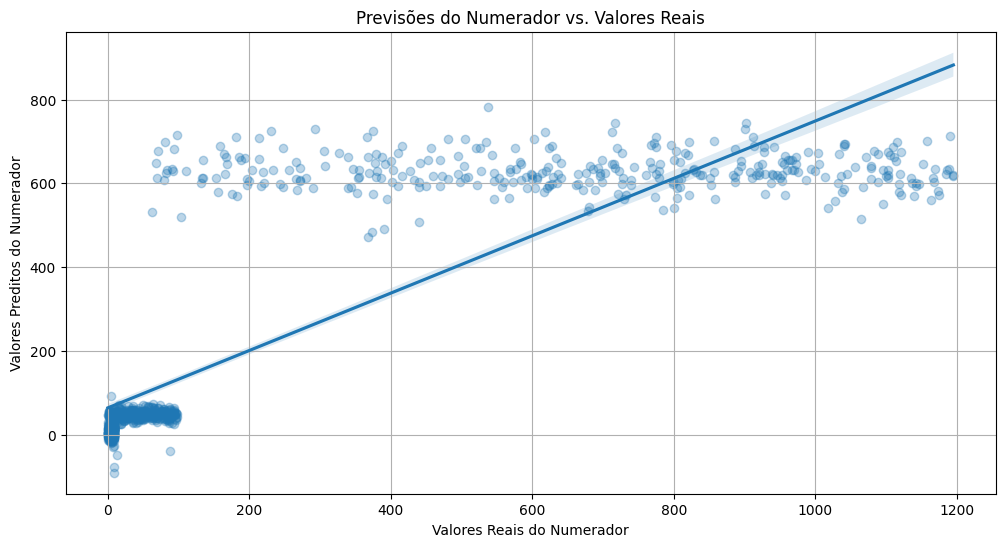

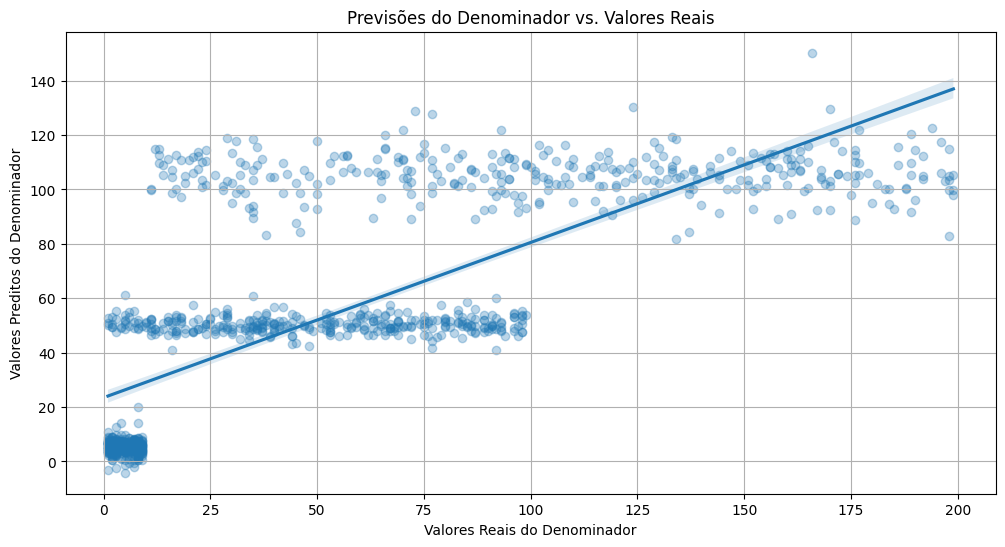

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualização para Numerador
plt.figure(figsize=(12, 6))
sns.regplot(x=y_numerador_test, y=y_numerador_pred, scatter_kws={'alpha':0.3})
plt.xlabel('Valores Reais do Numerador')
plt.ylabel('Valores Preditos do Numerador')
plt.title('Previsões do Numerador vs. Valores Reais')
plt.grid(True)
plt.show()

# Visualização para Denominador
plt.figure(figsize=(12, 6))
sns.regplot(x=y_denominador_test, y=y_denominador_pred, scatter_kws={'alpha':0.3})
plt.xlabel('Valores Reais do Denominador')
plt.ylabel('Valores Preditos do Denominador')
plt.title('Previsões do Denominador vs. Valores Reais')
plt.grid(True)
plt.show()

## Conclusão

Este notebook demonstrou um fluxo completo para a previsão de indicadores de call center usando Gradient Boosting, desde a geração de dados fictícios até a avaliação e visualização dos resultados. O modelo pode ser aprimorado com mais engenharia de features, otimização de hiperparâmetros e a inclusão de dados reais para maior precisão.